# Generative AI Design & Simulation for Integrated Photonics 
v0.2-beta
2024/09/30   
Paul Shen <pxshen@alumni.stanford.edu>

# Intro

*Open in [Colab](https://colab.research.google.com/github/paulxshen/Luminescent.jl/blob/master/Luminescent_AI_docs.ipynb) to view table of contents.*

[Luminescent AI](https://luminescentai.com/) brings generative AI to photonics and RF. It empowers engineers to create complex optimal components just in a few lines of code! Specifically we created an automatic differentiation (AD) and GPU compatible FDTD engine and geometry generator for simulation and inverse design of photonic integrated circuits (PIC), RF microstrip circuits, antennas and metasurfaces. Experimental release 🥼. Expect bugs 🐛🐞

[Follow us](https://www.linkedin.com/company/luminescent-ai/about) for updates and bug fixes!

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/n_O1r6wggLU?si=x2tKzw4hzrIz6h7C" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

# Links
[GitHub](https://github.com/paulxshen/Luminescent.jl): Star us :) We respond to issues within a day  
[LinkedIn](https://www.linkedin.com/company/luminescent-ai/about): Follow us for new features and bug fixes  
[Youtube](https://www.youtube.com/playlist?list=PLaK09N11V08geHeqyLJLDAW0tiDeJtnd4): Video tutorials  
[Company](luminescentai.com): Consulting, collaboration, funding, publication opportunities available  
[White Paper](https://docs.google.com/document/d/1b1kfDdRHw95AsR8zhrZYsHfCHLnULIO7uOYu8PxKQTM/edit?usp=sharing): Generative AI Cells for Semiconductor Photonics Design  
Email: pxshen@alumni.stanford.edu info@luminescentai.com  
WhatsApp: 650-776-7724  
WeChat: pxshen1230 懂中文

# Installation
## Windows
1. [Download](https://github.com/paulxshen/Luminescent.jl/releases) & unzip `Luminescent_AI.zip` backend binaries. Add **where_you_unzipped**\Luminescent_AI\bin to Path (using "edit environmental variables")
2. Install Anaconda distribution of Python . Inside  Anaconda Prompt do `pip install -U luminescent`
## Linux
Please request

# Usage and conventions

We do simulation and generative inverse design supporting multi wavelength and multi mode in 3D or 2.5D. Currently, simulation runs on CPU or GPU but generative design is only on CPU. 

We lay out using Python  gdsfactory which is integrated with KLayout. Can also import .gds into gdsfactory . Internally, gdsfactory component and layer stack let generate a 3D mesh which is clipped vertically some depths above and below `core_layer`. By default,
we apply a SOI 220nm node (Si, SiN and Ge layers) implemented by [`gdsfactory.generic_tech`](https://gdsfactory.github.io/gdsfactory/notebooks/03_layer_stack.html#layerstack) layer stack. `luminescent.MATERIALS` maps the material tag of a layer in the layer stack to its property eg `MATERIALS["si"]["epsilon"]`. Can create your own LAYER_STACK and MATERIALS for your process node.

We automatically extend waveguides and adds margins during simulation but port locations remain fixed thus not affecting sparams. Port numbers map to gdsfactory component ports. Specify port pairs as eg `2,1` which is equivalent to `o2@0,o1@0` meaning optical_port_number@mode_number. 

Each simulation or design optimization run is saved to a folder named after `name` arg or (if unnamed) timestamp string. These run folders are inside working directory `wd="runs"` which can be modified by passing to `write_sparams` or `gcell_problem`. Can access saved runs via `show_solution()`, `load_solution()`, `finetune()` which act on latest modified run folder inside `wd` if `name` not specified.  





# Generative AI inverse design
We introduce GCells (generative cells), a natural evolution of PCells (parametric cells) in semiconductor design . Given a set of inverse design objectives, a GCell will generate optimal geometry using adjoint optimization while ensuring manufacturability by enforcing minimum feature lengths.

In examples below, `gcells.mimo` (multi in multi out) is just a gdsfactory component with configurable waveguide ports, simple slab as pre-optimization geometry, and overlying rectangular design regions. Dimensions `l` along x and `w` along y. Ports are numbered incrementally: west (SW->NW) -> east (SE->NE) -> south (SW->SE) -> north (NW->NE). By default, they're spaced equally on a side. Example: `west=1, east=2` places port 1 on west, ports 2 & 3 on east. But can also individually specify their locations and widths. Example : `west=[1.0, 2.5], wwg_west=[0.5, 0.4]`.

Optimization `targets` is a dictionary organized wrt target type & wavelength. Types include T-params (`tparams`, most common), phase difference (`phasediff`), S-params (`sparams`). Multiple types & wavelengths are possible & often necessary . Loss for each type is scaled automatically to vary from 0 to 1 usually . For example , `tparam` loss of 0.5 roughly means 50% of power going to wrong places.

`lvoid` is minimum length scale for voids. No void features smaller than it. Similarly for `lsolid`

`approx_2D=True` optimizes in 2.5D which is significantly faster than 3D. Examples done at low resolution and lax convergence in 2.5D on CPU. For accuracy, the result must be finetuned in 3D at finer resolution, a feature that can be requested from Luminescent AI .


## Generative cells PDK for passive devices 


### mode converter
We target "o2@1,o1@0", converting optical port 1 mode TE0 input to optical port 2 mode TE1 ouput at 1.55um. Mode converters are notoriously hard to design, but generative AI does it in a pinch! 

In [ ]:
# recommended RAM: >16G
from pprint import pprint
import luminescent as lumi

name = "mode_converter"  # can be any string
c = lumi.gcells.mimo(west=1, east=1, l=6.0, w=3.0,
                     wwg=.5, taper=.05, name=name)
targets = {"tparams": {1.55: {"o2@0,o1@1": 1.0}}}

prob = lumi.gcell_problem(
    c, targets,
    lvoid=0.2, lsolid=.1, dx=0.05,
    approx_2D=True, iters=60, stoploss=.03)
sol = lumi.solve(prob)

2024-09-29 23:57:44.202 | WARNING  | kfactory.conf:_validate_layout_cache:254 - 'cell_layout_cache' has been set to True. This might cause when as any cell names generated automatically are loaded from the layout instead of created. This could happen e.g. after reading a gds file into the layout.


Can optionally optimize more using `finetune`

In [ ]:
# sol=lumi.finetune(iters=10,name=name)

Lets see simulation fields and optimized gdsfactory component. It's also saved as `optimized_component.gds` in run folder. Can also find `design_region_1.gds` and `design_region_1.png` for just the optimized design regions.

2024-09-29 23:58:13.183 | WARNING  | kfactory.conf:_validate_layout_cache:254 - 'cell_layout_cache' has been set to True. This might cause when as any cell names generated automatically are loaded from the layout instead of created. This could happen e.g. after reading a gds file into the layout.
showing solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\mode_converter
loading solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\mode_converter
Converting an image file to a GDS file..
width:120
height:60
2024-09-29 23:58:24.054 | WARNING  | gdsfactory.component:__setattr__:185 - Setting `Unnamed_11_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_11_0_0.dxmin` instead. For further information, please consult the migration guide: 
2024-09-29 23:58:24.059 | WARNING  | gdsfactory.component:__setattr__:185 - Setting `Unnamed_11_0_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please u

C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:171: UserWarning: Setting `Unnamed_11_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_11_0_0.dxmin` instead.
  g.xmin = x0
C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:172: UserWarning: Setting `Unnamed_11_0_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_11_0_0.dymin` instead.
  g.ymin = y0


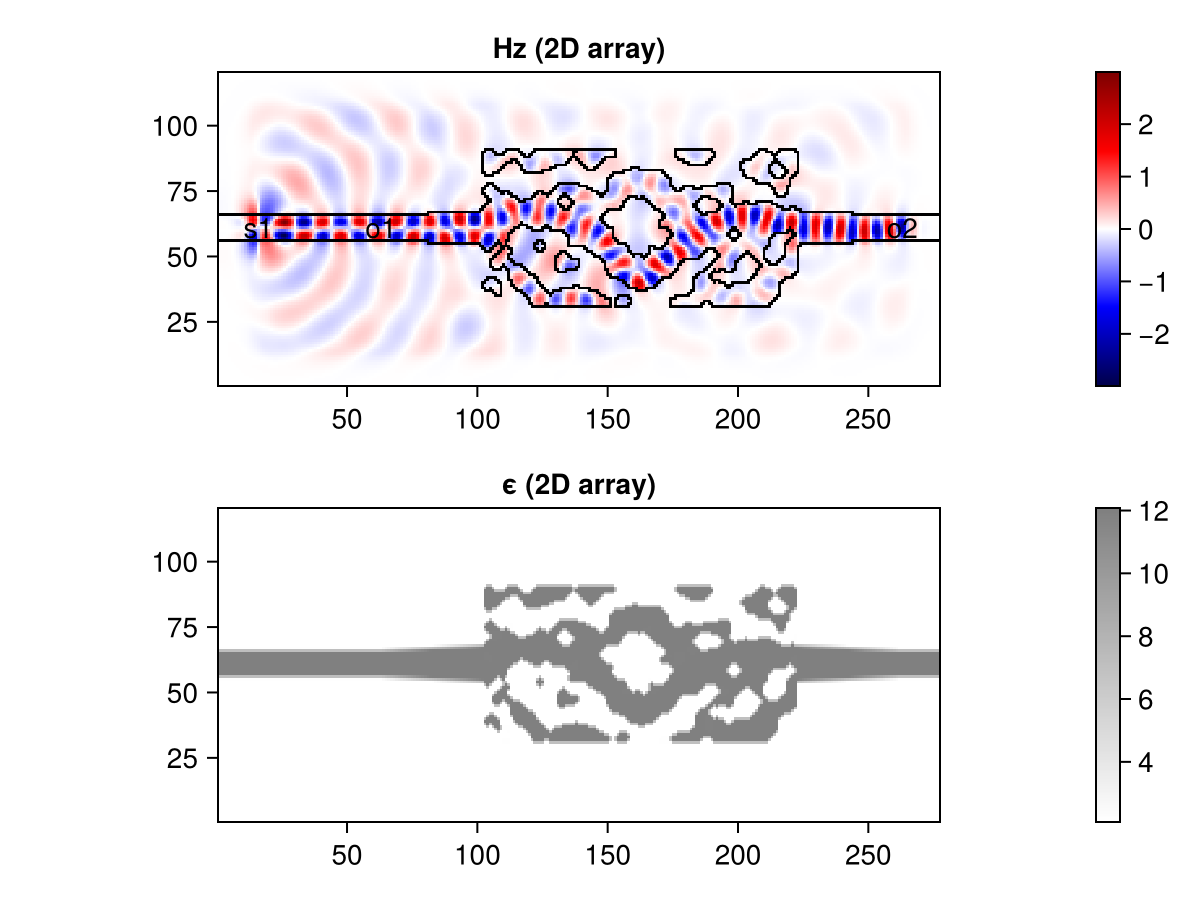

2024-09-29 23:58:28.314 | WARNING  | gdsfactory.component:__setattr__:185 - Setting `Unnamed_16_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_16_0_0.dxmin` instead. For further information, please consult the migration guide: 
2024-09-29 23:58:28.318 | WARNING  | gdsfactory.component:__setattr__:185 - Setting `Unnamed_16_0_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_16_0_0.dymin` instead. For further information, please consult the migration guide: 


In [1]:
import luminescent as lumi 
name="mode_converter"
lumi.show_solution(name=name)

loading solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\mode_converter
Converting an image file to a GDS file..
width:120
height:60


C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:171: UserWarning: Setting `Unnamed_16_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_16_0_0.dxmin` instead.
  g.xmin = x0
C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:172: UserWarning: Setting `Unnamed_16_0_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_16_0_0.dymin` instead.
  g.ymin = y0


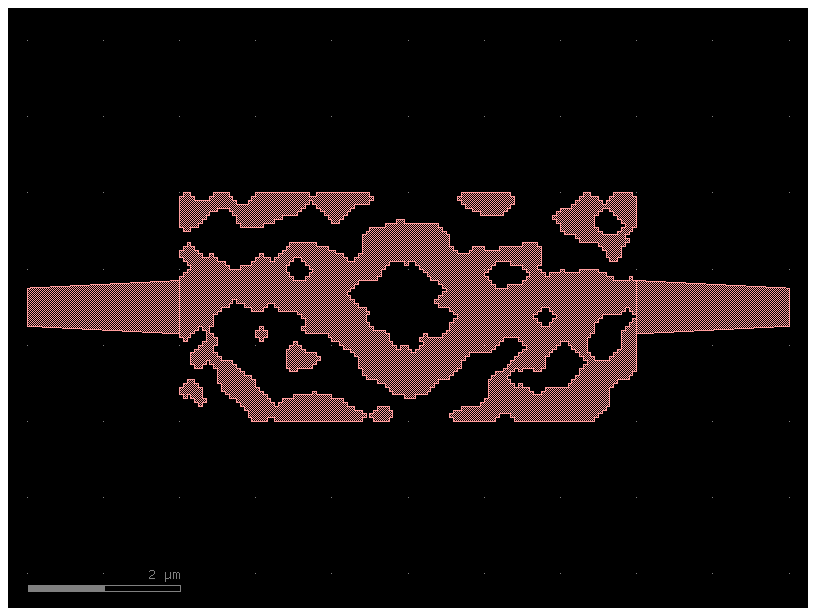

In [2]:
sol=lumi.load_solution(name=name)
sol["optimized_component"].plot()

### 1x2 splitter MMI
1.55um wavelength 1x2 splitter. We set symmetry about y so only need to specify T21=1.0 as optimization target. Data saved to `name` folder inside working directory. We start iteratiions of adjoint optimization.

In [ ]:
from pprint import pprint
import luminescent as lumi

name = "1x2_splitter"
c = lumi.gcells.mimo(west=1, east=2, l=4.0, w=2.0, wwg=.5, name=name)
targets = {"tparams": {1.55: {"2,1": 0.5, "3,1": 0.5}}}

prob = lumi.gcell_problem(
    c, targets,
    symmetries=[1], lvoid=0.1, dx=0.05,
    approx_2D=True, iters=30, stoploss=.03)
sol = lumi.solve(prob)


In an anticlimatic turn of events, optimization stops after a couple iterations as `stoploss` threshold is reached. Turns out the slab initial condition is already a good splitter  :D

showing solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\1x2_splitter
loading solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\1x2_splitter
Converting an image file to a GDS file..
width:80
height:40
{'path': 'C:\\Users\\pxshe\\OneDrive\\Desktop\\Luminescent.jl\\runs\\1x2_splitter',
 'sparams': {'1.55': {'o1@0,o1@0': (-0.02497092-0.025129166j),
                      'o1@1,o1@0': (0.0045466204-0.0023630492j),
                      'o2@0,o1@0': (-0.50640124+0.50496256j),
                      'o2@1,o1@0': (0.0054302337+0.044088982j),
                      'o3@0,o1@0': (-0.48066247+0.5202666j),
                      'o3@1,o1@0': (0.039007787-0.10546609j)}},
 'tparams': {'1.55': {'o1@0,o1@0': 0.0012550219,
                      'o1@1,o1@0': 2.6255759e-05,
                      'o2@0,o1@0': 0.5114294,
                      'o2@1,o1@0': 0.0019733259,
                      'o3@0,o1@0': 0.50171375,
                      'o3@1,o1@0': 0.012644704}}}


C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:163: UserWarning: Setting `Unnamed_28_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_28_0_0.dxmin` instead.
  g.xmin = x0
C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:164: UserWarning: Setting `Unnamed_28_0_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_28_0_0.dymin` instead.
  g.ymin = y0


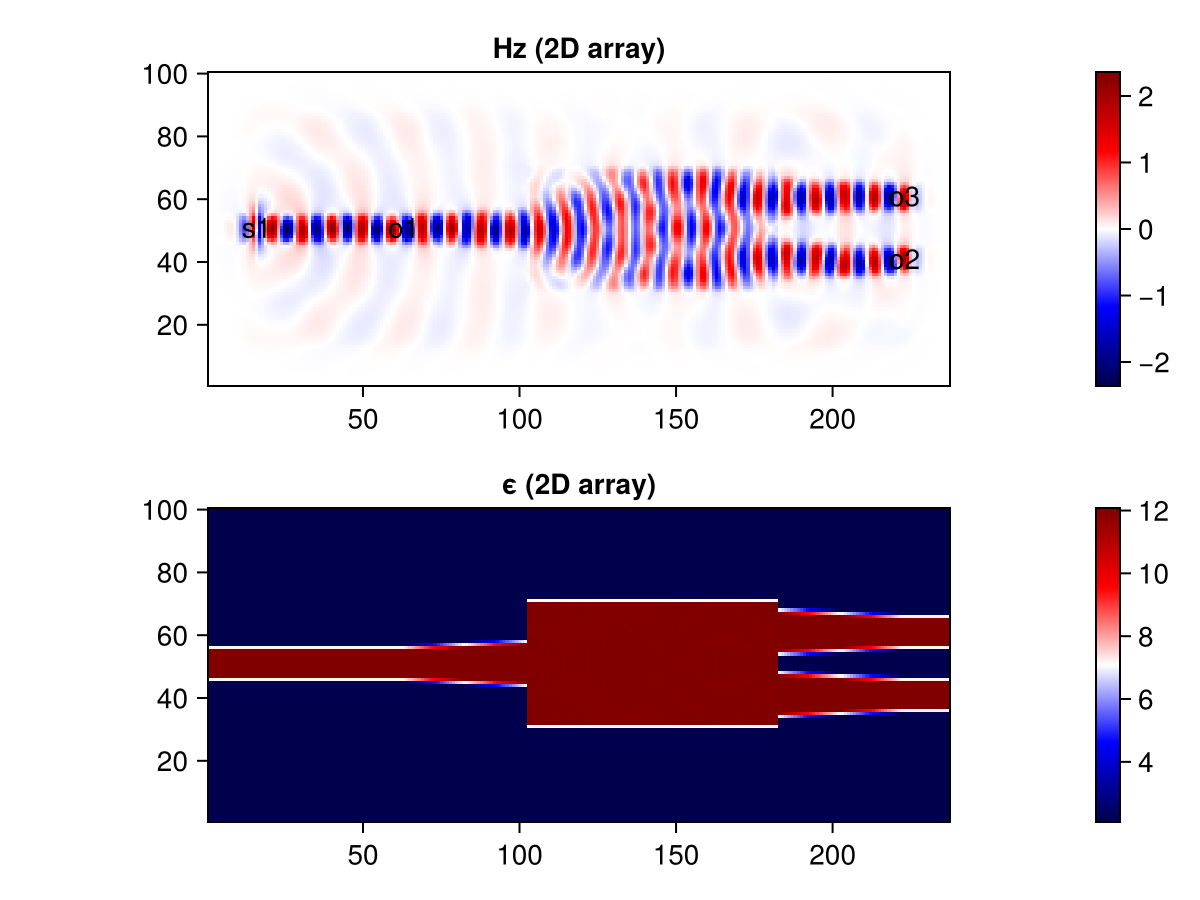

In [2]:
# import luminescent as lumi 
lumi.show_solution()

loading solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\1x2_splitter
Converting an image file to a GDS file..
width:80
height:40


C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:163: UserWarning: Setting `Unnamed_33_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_33_0_0.dxmin` instead.
  g.xmin = x0
C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:164: UserWarning: Setting `Unnamed_33_0_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_33_0_0.dymin` instead.
  g.ymin = y0


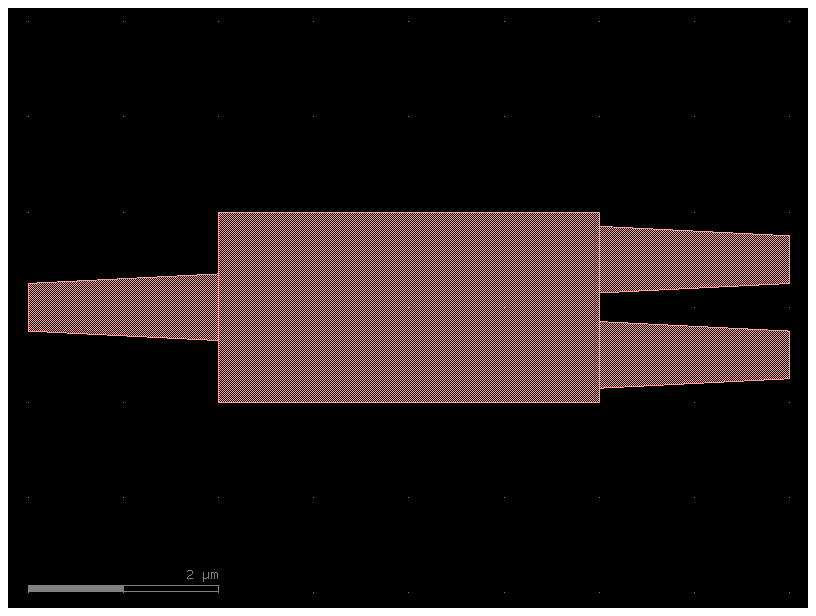

In [3]:
sol=lumi.load_solution()
sol["optimized_component"].plot()

### 1x4 splitter MMI
1x4 splitter at 1.55um with same phase on outputs. Because of symmetry, only need 0.0 phase difference between first 2 outputs.

In [ ]:
from pprint import pprint
import luminescent as lumi

name="1x4_splitter"
c = lumi.gcells.mimo(west=1, east=4, l=8.0, w=4.0, wwg=.5, name=name)
targets = {
    "tparams":{1.55: {"2,1": 0.25, "3,1":0.25}},
    "phasediff":{1.55: {"2,3": 0.0}},
    }

prob = lumi.gcell_problem(
    c, targets, 
    symmetries=[1], lvoid=0.2,lsolid=0.1, dx=0.05, 
    approx_2D=True, stoploss=.05, iters=40)
sol = lumi.solve(prob)

In [ ]:
# finetune(iters=10,name=name)
lumi.show_solution()

In [ ]:
c_opt=sol["optimized_component"]
c_opt.plot()

### wavelength domain demultiplexer

In [ ]:
# RAM: 32G
from pprint import pprint
import luminescent as lumi

name="demux"
c = lumi.gcells.mimo(west=1, east=2, l=4.0, w=4.0, wwg=.5, name=name)
targets = {"tparams":{
    1.55: {"2,1": 1.0},
    1.20: {"3,1": 1.0},
}}

prob = lumi.gcell_problem(
    c, targets,
    lvoid=0.2,lsolid=0.1, dx=0.05, 
    approx_2D=True, iters=50)
sol = lumi.solve(prob)

In [ ]:
name="demux"
lumi.show_solution()

### symmetric crossing 

In [ ]:
from pprint import pprint
import luminescent as lumi

c = lumi.gcells.mimo(west=1, east=1, south=1, north=1, l=4.0, w=4.0, wwg=.5, name="crossing")
targets = {"tparams":{1.55: {"2,1": 1.0}}}

prob = lumi.gcell_problem(
    c, targets,
    lvoid=0.2,lsolid=0.1, dx=0.05, symmetries=[0,"diag"],
    approx_2D=True, iters=40)
sol = lumi.solve(prob)

In [ ]:
lumi.show_solution()

## GCells PDK for active  devices

### Thermo-optic phase shifters 
Please request 

## GCells PDK for nonlinear devices
Please request 

# S-parameters simulation (3D on GPU)

One can choose to do only a subset of sparams in case of symmetric devices by specifying `keys`. if `keys` omitted, all sparams will be calculated


## SOI 220nm

### straight Si waveguide 

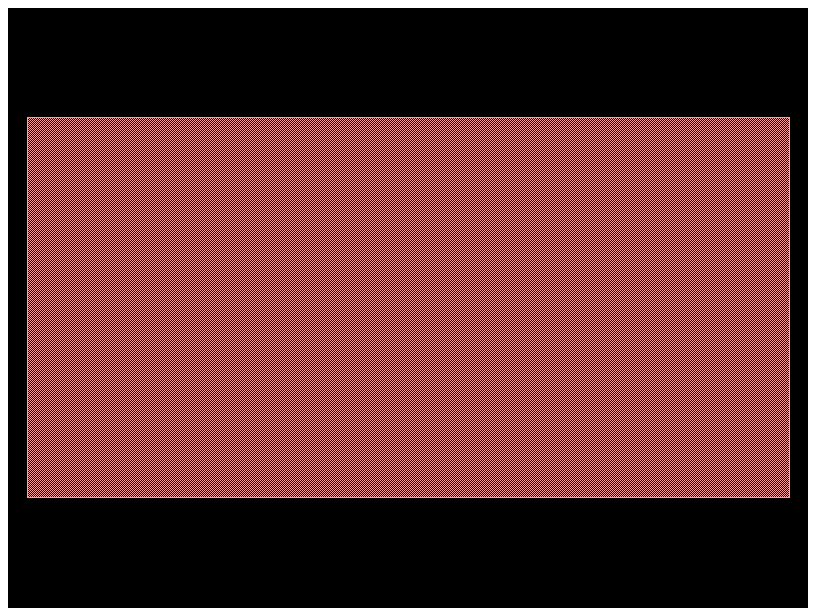

In [4]:
import luminescent as lumi
from luminescent import MATERIALS
from gdsfactory.generic_tech import LAYER,LAYER_STACK
import gdsfactory as gf
import pprint as pp

wg = gf.components.straight(length=0.8,width=0.4,layer=LAYER.WG)
wg.plot()

c=gf.Component()
c<<wg
c.add_ports(wg.ports)

#### TE0


          using simulation folder runs\2024-09-18T22-52-22#sparams
          started julia process
          compiling julia code...
          
setting up simulation...
using CUDA backend.
Computing s-parameters...
Done in 244.65300011634827 s
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\pxshe\.julia\packages\Flux\HBF2N\ext\FluxCUDAExt\FluxCUDAExt.jl:57

images and results saved in runs\2024-09-18T22-52-22#sparams
loading solution from runs\2024-09-18T22-52-22#sparams
showing solution from runs\2024-09-18T22-52-22#sparams
loading solution from runs\2024-09-18T22-52-22#sparams
{'path': 'runs\\2024-09-18T22-52-22#sparams',
 'sparams': {'1.55': {'o1@0,o1@0': (0.036693174+0.051523555j),
                      'o2@0,o1@0': (-0.5923665+0.79055756j)}},
 'tparams': {'1.55'

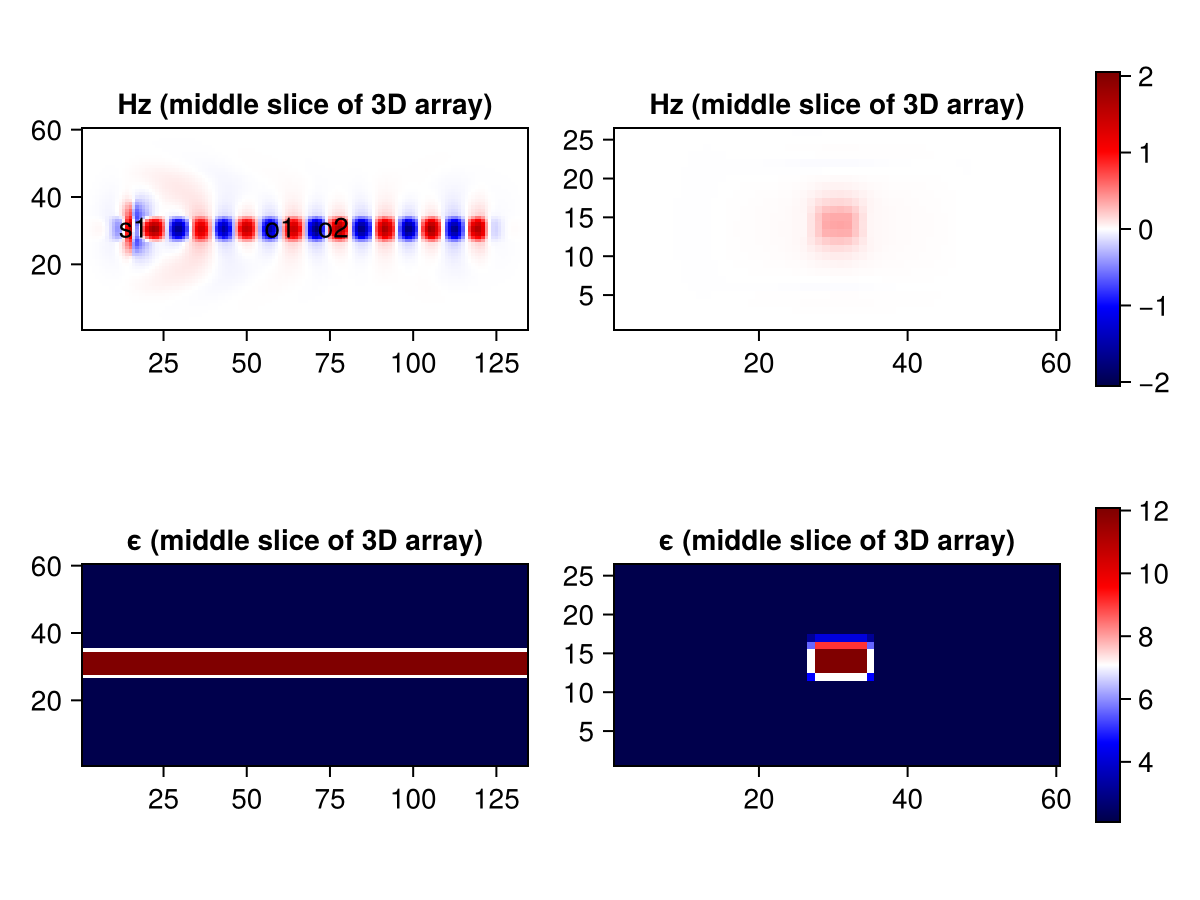

In [2]:
# name="wg_TE0"
sol = lumi.write_sparams(c, wavelength=1.55, keys=["2,1"], # same as keys=["o2@0,o1@0"]
                      core_layer=LAYER.WG,   bbox_layer=LAYER.WAFER, # defaults
                         layer_stack=LAYER_STACK, materials=MATERIALS, # defaults
     dx=0.05, approx_2D=False, dtype="float32", gpu="CUDA",) # or gpu=None
lumi.show_solution()

#### TE1


          using simulation folder C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\2024-09-19T13-21-07#sparams
          started julia process
          compiling julia code...
          
setting up simulation...
using CUDA backend.
Computing s-parameters...
Done in 44.09600019454956 s
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\pxshe\.julia\packages\Flux\HBF2N\ext\FluxCUDAExt\FluxCUDAExt.jl:57

images and results saved in C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\2024-09-19T13-21-07#sparams
loading solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\2024-09-19T13-21-07#sparams
showing solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\runs\2024-09-19T13-21-07#sparams
loading solution from C:\Users\pxshe\OneDrive\Desktop\Lumin

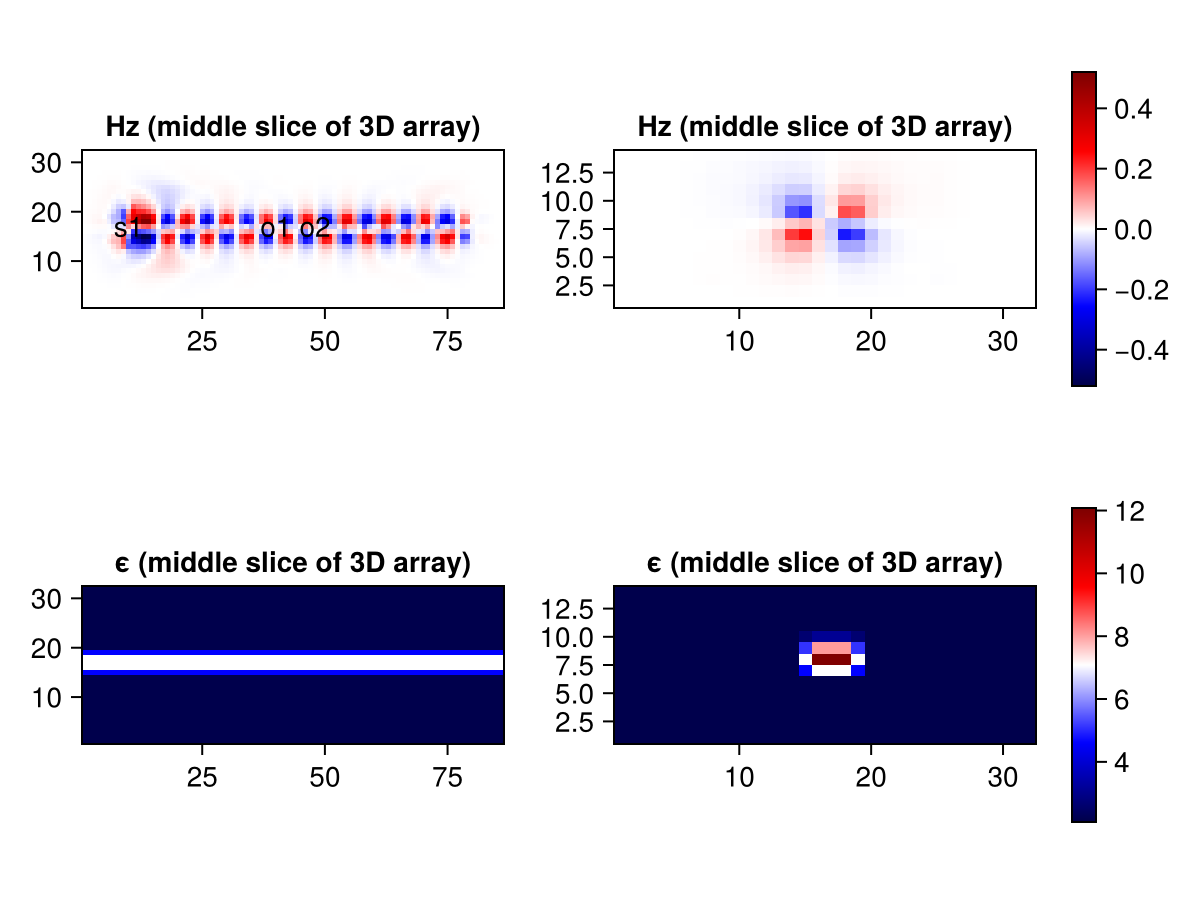

In [3]:
# name="wg_TE1"
sol = lumi.write_sparams(c, wavelength=1.55, keys=["o2@1,o1@1"],
     dx=0.1, approx_2D=False, dtype="float32", gpu="CUDA",) # or gpu=None
lumi.show_solution()

#### TE0 multiple wavelengths


          using simulation folder runs\2024-09-19T12-08-36#sparams
          started julia process
          compiling julia code...
          
setting up simulation...
using CUDA backend.
Computing s-parameters...
Done in 454.96200013160706 s
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\pxshe\.julia\packages\Flux\HBF2N\ext\FluxCUDAExt\FluxCUDAExt.jl:57

images and results saved in runs\2024-09-19T12-08-36#sparams
loading solution from runs\2024-09-19T12-08-36#sparams
showing solution from runs\2024-09-19T12-08-36#sparams
loading solution from runs\2024-09-19T12-08-36#sparams
{'path': 'runs\\2024-09-19T12-08-36#sparams',
 'sparams': {'1.25': {'o1@0,o1@0': (0.020658744+0.06863193j),
                      'o2@0,o1@0': (0.44891578-0.9070961j)},
             '1.55': {

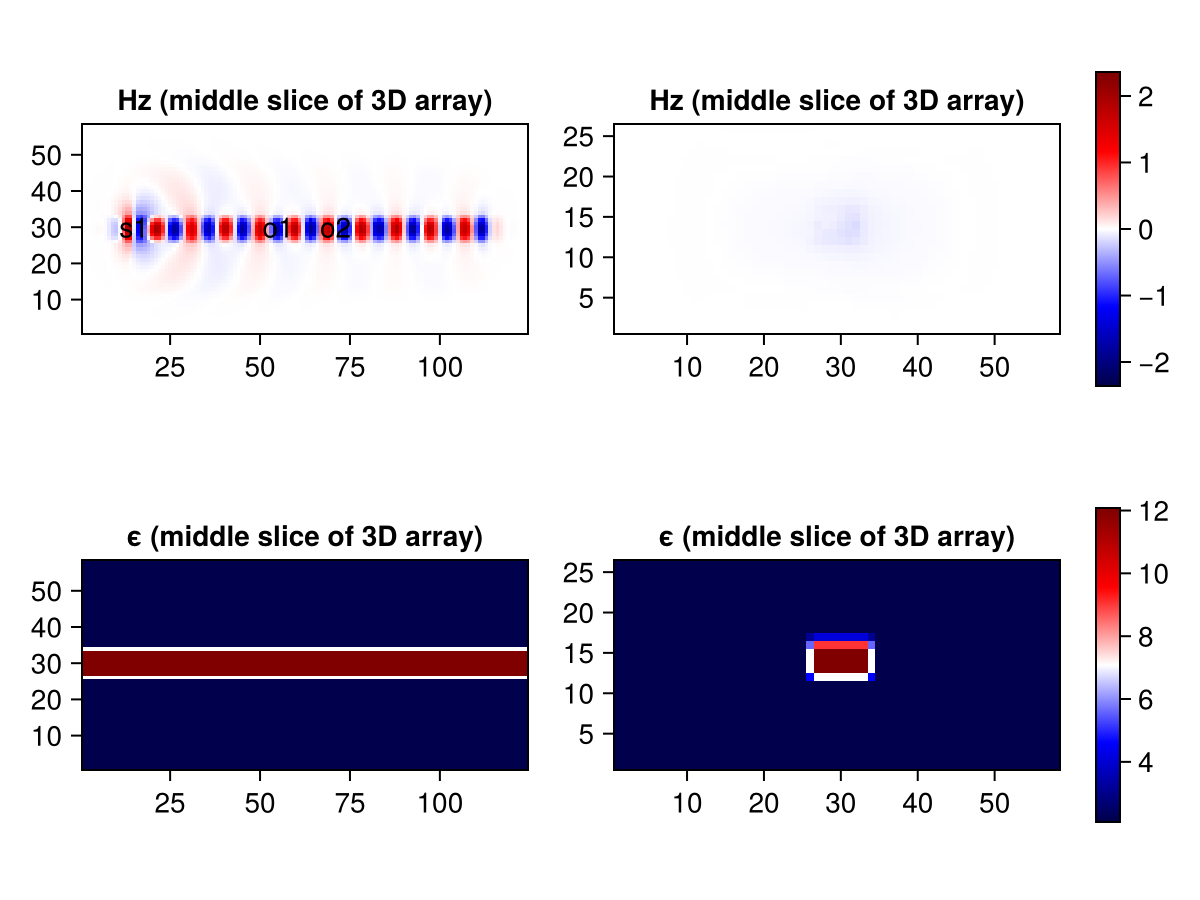

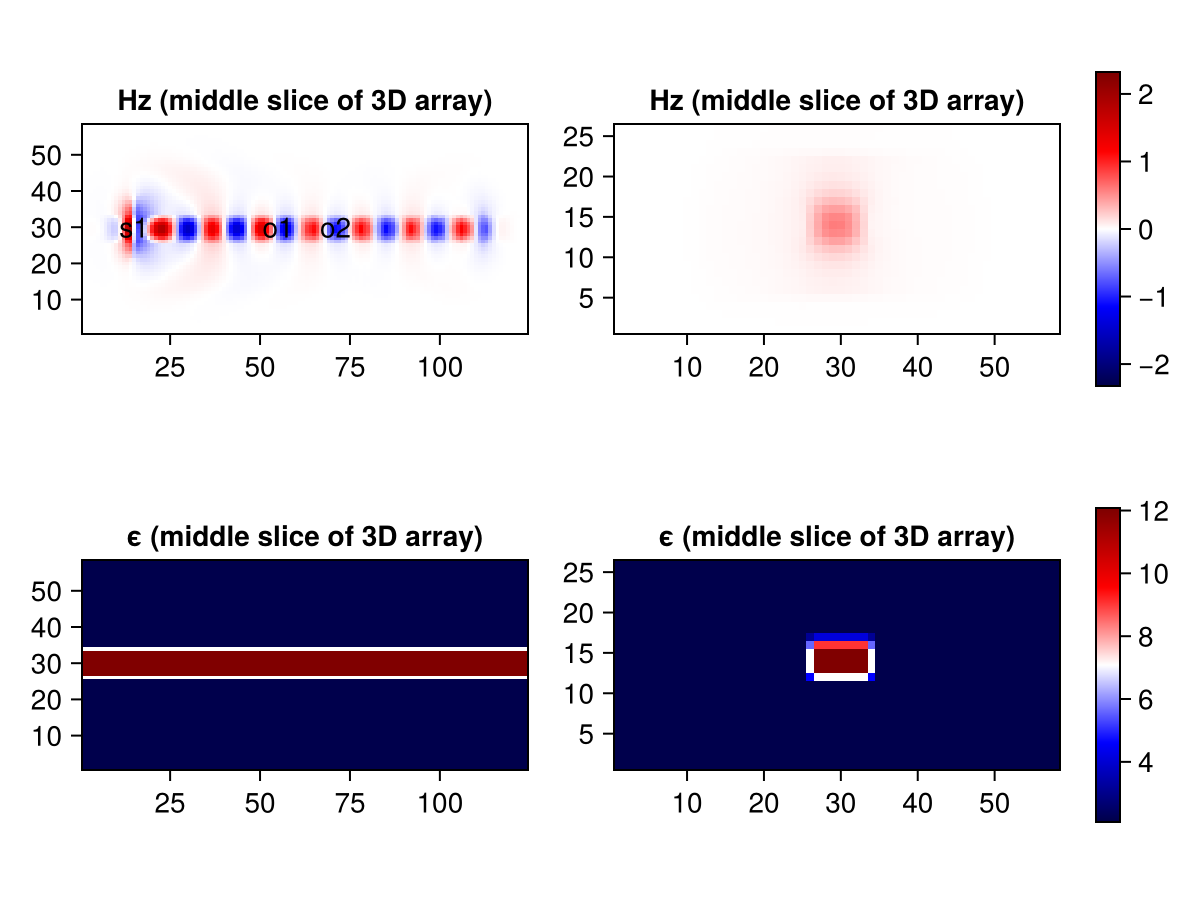

In [3]:
# name="wg_multi"
sol = lumi.write_sparams(c, wavelength=[1.25, 1.55], keys=["2,1"],
     dx=0.05, approx_2D=False, dtype="float32", gpu="CUDA",) # or gpu=None
# sol = lumi.load_solution()
lumi.show_solution()

### Si rib waveguide
only need to modify bbox_layer to include 90nm bottom silicon slab

In [ ]:
# name="wg_rib"
c=gf.Component()
c<<wg
c.add_ports(wg.ports)

sol = lumi.write_sparams(c, wavelength=1.55, keys=["2,1"], # same as keys=["o2@0,o1@0"]
                      core_layer=LAYER.WG,   bbox_layer=[LAYER.WAFER,LAYER.SLAB90],
     dx=0.05, approx_2D=False, dtype="float32", gpu="CUDA",) # or gpu=None
# sol = lumi.load_solution()
lumi.show_solution()

### SiN strip waveguide

In [ ]:
import luminescent as lumi
from luminescent import MATERIALS
from gdsfactory.generic_tech import LAYER,LAYER_STACK
import gdsfactory as gf

# name="wg_SiN"
wg = gf.components.straight(length=1.5,width=1.0,layer=LAYER.WGN)
c=gf.Component()
c<<wg
c.add_ports(wg.ports)

sol = lumi.write_sparams(c, wavelength=1.55, keys=["2,1"], # same as keys=["o2@0,o1@0"]
                      core_layer=LAYER.WGN,   bbox_layer=LAYER.WAFER, # defaults
     dx=0.05, approx_2D=False, dtype="float32", gpu="CUDA",) # or gpu=None
# sol = lumi.load_solution()
lumi.show_solution()

# Advanced features
Following can be requested from info@luminescentai.com (mention your position and organization ): inverse design
-d finetuning
- inverse design of active or nonlinear devices GPU